<h1 style = "text-align: center"> SPAM CLASSIFIER </h1>
    
**Objective:** To classify emails as spam or not spam based entirely on the message they provide (ignoring all other details like the letter head, sender, html formatting, grammar, etc) 

## Notebook Imports

In [ ]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split 

%matplotlib inline

## Constants

In [ ]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt" 

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"

EASY_HAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_HAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-id-data.csv"

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TRAINING_DATA_FILE_CSV = 'SpamData/02_Training/train-data.csv'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'
TEST_DATA_FILE_CSV = 'SpamData/02_Training/test-data.csv'

#naming conventions for constants are capitalized words separated by underscores.

## Reading Files

In [ ]:
stream = open(EXAMPLE_FILE, encoding = "latin-1")  # Creating a file object (stream)
message = stream.read()                            # Reading and storing the contents from the file object (line by line ['\n'])
stream.close()                                     # Closing the file object

print(type(message))
print(message)

# The output below shows us the type of message variable, followed by a sample email that gives us the general template of the
# of all the emails we will be using for the project.

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [ ]:
import sys
sys.getfilesystemencoding()

# we are dealing with spam messages written only in english, and different machines may have different default encoding, we use 
# a different encoding for this project.

'utf-8'

In [ ]:
# Getting only the body

# As seen in the sample email, there is an empty line between the email header and the body.

stream = open(EXAMPLE_FILE, encoding = "latin-1")  

# In  all the scraped mails that make up the dataset, the body of the mail starts 
# after the first blank line, hence we can make use of the flag 'is_body'
is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()        

email_body = '\n'.join(lines) # to convert a list of strings into a single string 
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## EMAIL Body extraction using generator function

-  The walk function generates the filenames in a directory by walking the tree from the top to the bottom and it yields a  tuple of 3 things consisting the directory path, directory names and the filenames themselves.

In [ ]:
def email_body_generator(path):

    """
    This generator takes in a the path to a directory in which all the emails have been stored,
    it traverses the directory tree in a top to bottom format (like DFS), and reads all the files
    in the directory structure.

    Arguments:
      1. path (str): it is the path to the main folder under which all the mails are present

    Yields:
      1. filename (str): name of the file from which a scraped email is read
      2. email_body (str): body of the corresponding email
    """
    
    for root, dirnames, filenames in walk(path):        # walk function explained above
        
        for filename in filenames:
            
            filepath = join(root, filename)
            stream = open(filepath, encoding = "latin-1")  
            
            # In  all the scraped mails that make up the dataset, the body of the mail starts 
            # after the first blank line, hence we can make use of the flag 'is_body'
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()        

            email_body = '\n'.join(lines)
            
            yield filename, email_body

In [ ]:
def df_from_directory(path, classification):
    """
    This function takes in the path to a directory and the label for all the mails
    in the directory, and creates and returns a DataFrame out of it

    Arguments:
    1. path (str): path to the directory containing scraped mails 
    2. classification (bin): denotes whether the directory is for spam emails or 
                             ham emails

    Returns:
    1. A pandas DataFrame consisting of email bodies and their corresponding labels
       (spam or ham), indexed using the filenames of the mails
    """

    rows = []                                       
    row_names = []                                  
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'Message': email_body,'Category': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [ ]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)     # Let 1 denote spam emails, and 0 denote non-spam
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))

ham_emails = df_from_directory(EASY_HAM_1_PATH, 0)
ham_emails = ham_emails.append(df_from_directory(EASY_HAM_2_PATH, 0))

In [ ]:
# Number of spam mails in the dataset
spam_emails.shape

(1898, 2)

In [ ]:
# Number of non-spam mails in the dataset
ham_emails.shape

(3901, 2)

In [ ]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of our dataset: ", data.shape)
data.head()

Shape of our dataset:  (5799, 2)


,Message,Category
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# DATA CLEANING

## NULL VALUES

In [ ]:
# Checking if any of the email bodies are null 
data.Message.isnull().values.any()   
# .values returns a list without indices and any() will return true if there is atleast 1 true in the list

False

## EMPTY BODIES

In [ ]:
# Checking if there are any emails with empty (length = 0) bodies in our dataset
(data.Message.str.len() == 0).any()

True

In [ ]:
# Getting the exact number of messages that are empty strings
(data.Message.str.len() == 0).sum()

3

### LOCATING EMPTY EMAILS

In [ ]:
type(data.Message.str.len() == 0)

pandas.core.series.Series

In [ ]:
# the datatype of the object returned by the above conditional is a pandas series, hence we can use it for Boolean indexing
# Getting the indices of the files with no email bodies
data[data.Message.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [ ]:
# The cmds files are actually system files that dont belong in the email corpus. 
# The walk() function used by us walks through all the files in the directory, hence we ended up adding system files to our data

### REMOVE SYSTEM FILE ENTRIES FROM THE DATAFRAME

In [ ]:
data.drop(['cmds'], inplace = True)
data.shape

(5796, 2)

## GIVING SEQUENTIAL ID's TO EMAILS FOR EASY ACCESS

In [ ]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [ ]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,Message,Category,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [ ]:
data.tail()

,Message,Category,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


## Saving Cleaned Data to a JSON File

This will help us by saving the time we require to preprocess data every time we open the notebook.

In [ ]:
data.to_json(DATA_JSON_FILE)

# Data Exploration and Visualization

In [ ]:
data.Category.value_counts()

0    3900
1    1896
Name: Category, dtype: int64

In [ ]:
spam_count = data.Category.value_counts()[1]
ham_count = data.Category.value_counts()[0]

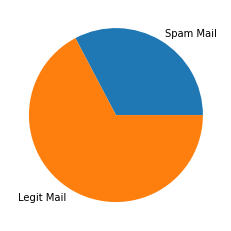

In [ ]:
category_names = ['Spam Mail', 'Legit Mail']
sizes = [spam_count, ham_count]

# Pie-Chart (Spam Mail vs Legit(Ham) Mail)
plt.pie(sizes, labels = category_names)
plt.show()

**NOTE:** Sharper images ofcharts are good for storing and using in your reports as they have much higher resolution and hence, are more presentable.

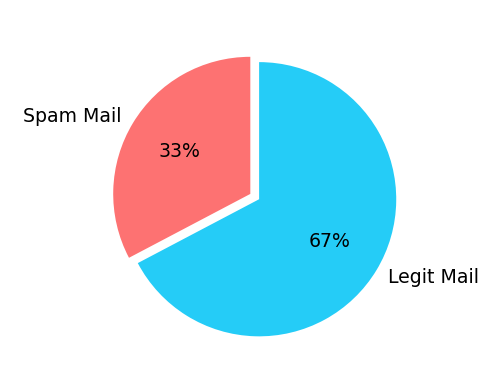

In [ ]:
custom_colors = ['#FD7272','#25CCF7']

plt.figure(figsize = (2,2), dpi = 227)    # dpi = density per inch, higher dpi means sharper image
plt.pie(sizes, labels = category_names, textprops= {'fontsize': 6}, autopct = '%1.0f%%', startangle = 90,
       colors = custom_colors, explode = [0, 0.075])
plt.show()

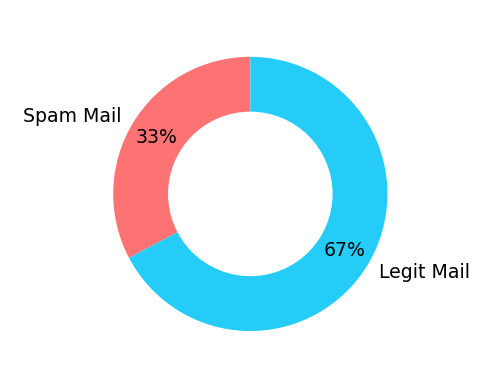

In [ ]:
custom_colors = ['#FD7272','#25CCF7']

plt.figure(figsize = (2,2), dpi = 227)    # dpi = density per inch, higher dpi means sharper image
plt.pie(sizes, labels = category_names, textprops= {'fontsize': 6}, autopct = '%1.0f%%', startangle = 90,
       colors = custom_colors, pctdistance = 0.8)

center_circle = plt.Circle((0, 0), radius = 0.6, fc = 'white')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

## Text Preprocessing

In [ ]:
# nltk needs a certain component to be downloaded onto the local machine before becoming usable

nltk.download('punkt') # Sentence Tokenizer: divides a text into a list of sentences by using an 
                       # unsupervised algorithm

nltk.download('stopwords') # A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
                           # that a search engine has been programmed to ignore, these dont contribute 
                           # much to the meaning of the sentences

[nltk_data] Downloading package punkt to C:\Users\Hammad
[nltk_data]     Khan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hammad
[nltk_data]     Khan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Glossary

- **tokenizing** words means separating every word and punctuations. (unlike the split() function, it is able to separate the string 'apples, mangoes and bananas' to ['apples', ",", 'mangoes', 'and', 'bananas'], even the punctuation "," becomes a separate token.

- **stop_words** are the words in a statement that do not contribute significantly to the meaning of the statement, however, these words are essential in terms of grammar. Eg: and, or, the, a, would, should'nt, etc.

- **word stemming** is the practice of reducing a word to its base form. Since for our purpose, we only need to concern ourselves with the meaning of words and not the different forms of them (this would just increase the workload and hence, waste time), stemming will greatly improve our model. 

In [ ]:
def clean_msg(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    # Removing HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converting to lower case and splitting message into a list of words (for the bag of words approach)
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    #Removing stop_words and punctuation, and stemming all the words to their base form
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [ ]:
# Testing our function on a sample
clean_msg(data.at[2, 'Message'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

- df.at[ x_name, y_name ]
- df.iat[ i , j ]
- df.iloc[ i:i+k ]

## Processing the text of all messages in our dataset

In [ ]:
%%time
nested_list = data.Message.apply(clean_msg)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 2min 12s


In [ ]:
# ignoring BeautifulSoup's warning for opening a website as its irrelevant here
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: Message, dtype: object

## Getting the most used words in spam and ham emails

In [ ]:
doc_id_spam = data[data.Category == 1].index
doc_id_ham = data[data.Category == 0].index

In [ ]:
nested_list_spam = nested_list.loc[doc_id_spam]
nested_list_ham = nested_list.loc[doc_id_ham]

In [ ]:
word_count_list_spam = pd.Series([word for sublist in nested_list_spam for word in sublist]).value_counts()
word_count_list_ham = pd.Series([word for sublist in nested_list_ham for word in sublist]).value_counts()

In [ ]:
word_count_list_ham

http                  7563
use                   3633
list                  2880
one                   2373
get                   2286
                      ... 
crave                    1
seekabl                  1
dehlongi                 1
confiendnc               1
searchtemplatepath       1
Length: 20815, dtype: int64

In [ ]:
word_count_list_spam

http           3097
email          3090
free           2585
click          2058
receiv         1989
               ... 
nontradit         1
forafre           1
òåáìøîùå          1
gbbandwidth       1
drag              1
Length: 13242, dtype: int64

## Generate Vocabulary and Dictionary

In [ ]:
flat_stemmed_list = [item for sublist in nested_list for item in sublist]

In [ ]:
unique_words = pd.Series(flat_stemmed_list).value_counts()

In [ ]:
# Total number of unique stemmed words in all our emails
print("Total number of unique stemmed words = ", unique_words.shape[0])

Total number of unique stemmed words =  27334


In [ ]:
frequent_words = unique_words.iloc[0:VOCAB_SIZE]
type(frequent_words)

pandas.core.series.Series

### Vocab Dataframe and CSV

In [ ]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORDS': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_IDS'
vocab.head()

,VOCAB_WORDS
WORD_IDS,
0,http
1,use
2,list
3,email
4,get


In [ ]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header = vocab.VOCAB_WORDS.name)

## Finding the largest email

In [ ]:
clean_email_lengths = [len(sublist) for sublist in nested_list]
print("No. of words in the longest email: ", max(clean_email_lengths))

No. of words in the longest email:  7671


In [ ]:
print("Position of the email in our dataframe: ", np.argmax(clean_email_lengths))

Position of the email in our dataframe:  5775


In [ ]:
# Cross-checking if the clean message at the index 5775 has the same number of words 
len(nested_list.iloc[5775])

7671

In [ ]:
# The longest clean email
data.at[np.argmax(clean_email_lengths), 'Message']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generating Features and Sparse Matrix

In [ ]:
word_columns_df = pd.DataFrame.from_records(nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
word_columns_df.shape

(5796, 7671)

**Note:** The shape of the above dataframe is (5796, 7671) because the dataframe consists of 5796 rows for the 5796 emails, and 7671 is the maximum number of unique stemmed words in any of the emails of our dataset as we discovered in the previous section.

## Splitting training and testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.Category, test_size = 0.3, random_state = 42)

In [ ]:
X_train.shape

(4057, 7671)

In [ ]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: Category, dtype: int64

## Creating a Sparse Matrix for the training data

Creating an 'index' datatype of all the words in the 'vocab' dataframe so we can use the get_loc function to directly access the position of the word in the vocab df.

**Sparse Matrix:** My sparse matrix will contain a single entry for all the occurences of a frequent word (top 2500 most occuring words across all emails in this case) in every email. It will have the columns
- DOC_ID representing a unique id for every single email
- WORD_ID representing a unique id for every frequent word
- OCCURENCES representing the total number of times a frequent word occured in an email
- LABEL representing whether the email is spam or legit

In simple terms, we can say that the combination of the WORD_ID and the DOC_ID can act as a key for the resultant matrix. 

Our matrix will be sparse, implying that it will not include an entry for a frequent word and an email, such that the frequent word did not occur even once in that email.


In [ ]:
word_index = pd.Index(vocab.VOCAB_WORDS)

In [ ]:
word_index.get_loc('thu')

393

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):

    nr_rows = df.shape[0]             # number of documents
    nr_cols = df.shape[1]             # maximum number of stemmed words in an email
    word_set = set(indexed_words)     # using sets for membership checking
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:
%%time 
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 34min 44s


In [ ]:
sparse_train_df.shape

(429246, 4)

In [ ]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1237
2,0,4844,1,503
3,0,4844,1,308
4,0,4844,1,254


In [ ]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429241,1,860,1,47
429242,1,860,1,1431
429243,1,860,1,26
429244,1,860,1,21
429245,1,860,1,126


In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [ ]:
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [ ]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


Below we verify that the word with id = 7, occurs exactly 3 times in the email with DOC_ID = 0

In [ ]:
vocab.iat[7, 0]

'free'

In [ ]:
vv = clean_msg(data.Message[0])
count = 0
for word in vv:
    if word == 'free':
        count += 1
print(count)

3


In [ ]:
train_grouped.shape

(258371, 4)

As evident above, by grouping up the many occurences of the same stemmed word in the same email, we significantly reduce the size of the sparse matrix.

## Saving the training data as a file

In [ ]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d') #fmt stands for format (of numbers)

In [ ]:
train_grouped.to_csv(TRAINING_DATA_FILE_CSV, index_label = train_grouped.index.name, header = train_grouped.columns)

## Creating and saving a sparse matrix for the test data

In [ ]:
X_test.shape

(1739, 7671)

In [ ]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 4min 14s
Parser   : 211 ms


In [ ]:
sparse_test_df.shape

(203377, 4)

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [ ]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [ ]:
test_grouped.shape

(117782, 4)

In [ ]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')

In [ ]:
test_grouped.to_csv(TEST_DATA_FILE_CSV, index_label = test_grouped.index.name, header = test_grouped.columns)

## Getting back our dataset from the saved files

In [ ]:
train_grouped = pd.read_csv(TRAINING_DATA_FILE_CSV)
train_grouped.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [ ]:
test_grouped = pd.read_csv(TEST_DATA_FILE_CSV)
test_grouped.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


## Lost Emails

In [ ]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [ ]:
len(train_doc_ids)

4013

In [ ]:
len(test_doc_ids)

1724

**NOTE:** As opposed to the 4057 unique emails (DOC_ID) we had in our training dataset, we now have only 4013 unique emails in our sparse matrix. We did not include 44 emails at all in our training sparse matrix. Similarly, we do not include 15 unique emails in our test sparse matrix. So where did we lose these emails?

The encrypted emails containing something like a public key (which is gibberish in terms of language) were the emails that were lost during the creation of our sparse matrix (because they did not contain even a single frequent word from the set of the 2500 most frequent words). The occurence of these encrypted emails was due to our selection of a decryption method (latin - 1 in our case) which was not able to decrypt a small subset of emails that ended up as encrypted messages in the end. 

Moreover, sometimes there's so much HTML in a document that while parsing through it, BeautifulSoup leaves nothing and returns an empty string. 

## OTHER TIPS:

- Use **TAB** to complete words
- Use **SHIFT + TAB** to get a quick documentation of any function

# Training


# Notebook Imports

In [ ]:
import numpy as np
import pandas as pd

# Constants

In [ ]:
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = 'SpamData/03_Testing/prob-ham.txt'
TOKEN_ALL_PROB_FILE = 'SpamData/03_Testing/prob-all.txt'

TEST_FEATURE_MATRIX = 'SpamData/03_Testing/test-features.txt'
TEST_TARGET_FILE =  'SpamData/03_Testing/test-target.txt'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

# Loading the data into a NumPy array

In [ ]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter = ' ', dtype = int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter = ' ', dtype = int)

In [ ]:
sparse_train_data

array([[   0,    2,    1,    1],
       [   0,    3,    1,    2],
       [   0,    4,    1,    1],
       ...,
       [5795, 2268,    0,    1],
       [5795, 2342,    0,    1],
       [5795, 2373,    0,    1]])

In [ ]:
print('Number of rows in training file: ', sparse_train_data.shape[0])
print('Number of rows in test file: ', sparse_test_data.shape[0])

Number of rows in training file:  258371
Number of rows in test file:  117782


In [ ]:
print('Number of unique emails in training data: ', np.unique(sparse_train_data[:, 0]).size)
print('Number of unique emails in test data: ', np.unique(sparse_test_data[:, 0]).size)

Number of unique emails in training data:  4013
Number of unique emails in test data:  1724


## Creating the Dataframe

In [ ]:
column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))

In [ ]:
index_names = np.unique(sparse_train_data[:, 0])

In [ ]:
full_train_data = pd.DataFrame(columns = column_names, index = index_names)
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
full_train_data.fillna(value = 0, inplace = True)
full_train_data

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating a full matrix from a sparse matrix

Our full matrix will have the columns doc_id, category, and a column for every different word_id (It will somewhat look like a one-hot encoded system that is not binary, but has the number of occurences of a particular word in an email displayed in each cell).

In [ ]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx = 0, word_idx = 1, cat_idx = 2, freq_idx = 3):
    """
    Form a full matrix from a sparse matrix. Return a pandas dataframe. The full matrix will have the 
    columns doc_id, category, and a column for every different word_id (It will somewhat look like a 
    one-hot encoded system that is not binary, but has the number of occurences of a particular word in
    an email displayed in each cell).
    
    Keyword arguments:
    sparse_matrix (numpy array) -- 2D array where each cell is a stemmed word used in a particular email
    nr_words (int) -- size of the vocabulary. Total number of tokens. 
    doc_idx (int) -- position of the document id in the sparse matrix. Default: 1st column
    word_idx (int) -- position of the word id in the sparse matrix. Default: 2nd column
    cat_idx (int) -- position of the label (spam is 1, nonspam is 0). Default: 3rd column
    freq_idx (int) -- position of occurrence of word in sparse matrix. Default: 4th column

    Returns:
    full_matrix (numpy array) -- 2D array as described above
    """
    
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:, 0])
    full_matrix = pd.DataFrame(columns = column_names, index = doc_id_names)
    full_matrix.fillna(value = 0, inplace = True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, 'DOC_ID'] = doc_nr
        full_matrix.at[doc_nr, 'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurence
    
    full_matrix.set_index('DOC_ID', inplace = True)
    return full_matrix

In [ ]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

Wall time: 9.27 s


In [ ]:
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,6,0,0,2,4,0,3,14,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
full_train_data.tail()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5789,0,3,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5790,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5791,0,3,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5794,0,1,1,1,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5795,0,3,4,2,0,5,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating the probability of spam

In [ ]:
full_train_data.CATEGORY.size

4013

In [ ]:
full_train_data.CATEGORY.sum()   # Since we categorized all spam emails using 1 

1248

In [ ]:
prob_spam = full_train_data.CATEGORY.sum()/full_train_data.CATEGORY.size
print("The probability of an email being spam is: ", prob_spam)

The probability of an email being spam is:  0.310989284824321


# Total Number of Words/Tokens

In [ ]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
email_lengths = full_train_features.sum(axis = 1)
email_lengths[:5]

DOC_ID
0     87
1     53
2     40
3    183
4     43
dtype: int64

In [ ]:
total_wc = email_lengths.sum() 
total_wc

429246

# Number of Words/Tokens in spam and legit mails

In [ ]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_lengths.shape

(1248,)

In [ ]:
spam_wc = spam_lengths.sum()
spam_wc

176336

In [ ]:
ham_lengths = email_lengths[full_train_data.CATEGORY == 0]
ham_lengths.shape

(2765,)

In [ ]:
ham_wc = ham_lengths.sum()
ham_wc

252910

In [ ]:
email_lengths.shape[0] - spam_lengths.shape[0] - ham_lengths.shape[0]

0

In [ ]:
print('Average number of words in our spam emails {:.0f}'.format(spam_wc / spam_lengths.shape[0]))
print('Average number of words in our non-spam emails: {:.0f}'.format(ham_wc / ham_lengths.shape[0]))

Average number of words in our spam emails 141
Average number of words in our non-spam emails: 91


As evident, spam emails tend to be longer than the rest.

## Sum of tokens occuring in spam messages

In [ ]:
full_train_features.shape

(4013, 2500)

In [ ]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]

In [ ]:
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_spam_tokens.tail()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1885,1,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1887,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1889,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1890,2,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1895,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
summed_spam_tokens = train_spam_tokens.sum(axis = 0) + 1   

**NOTE:** The reason for adding a 1 here is that the Bayes' Theorem involves quite a few multiplication and division operations, and since the tokens we are dealing with are the most frequent tokens across both spam and non-spam messages, if a token occurs in non-spam messages but does not occur even once in the spam messages, its total count will be reflected as 0 in the formula, giving us a '0' or an undefined value as the probability. 

This technique of adding a 1 to all entries to prevent the 0/undefined situation was introduced by the french mathematician Laplace and is known as Laplace's Smoothing

In [ ]:
summed_spam_tokens.head()

0    2179
1     935
2    1217
3    2022
4    1219
dtype: int64

In [ ]:
summed_spam_tokens.tail()

2495     6
2496     6
2497     9
2498    23
2499     1
dtype: int64

As evident from the cell above, the word with 'word_id = 2499', did not occur in any of the spam emails and would have led to the breakdown of our model, Laplace's smoothing saved the day for us. 

## Sum of tokens occuring in non-spam messages

In [ ]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
summed_ham_tokens = train_ham_tokens.sum(axis = 0) + 1
summed_ham_tokens.shape

(2500,)

In [ ]:
summed_ham_tokens.head()

0    5484
1    2590
2    2045
3     938
4    1612
dtype: int64

In [ ]:
summed_ham_tokens.tail()

2495    25
2496    25
2497    26
2498     9
2499    29
dtype: int64

## P(Tokens | Spam) : Probability of occurence of a token, given that the email is spam

In [ ]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_tokens_spam[:5]

0    0.012184
1    0.005228
2    0.006805
3    0.011306
4    0.006816
dtype: float64

In [ ]:
prob_tokens_spam.sum()

1.0

**NOTE:** By adding the vocabulary size, we are accounting for the usage of Laplace's smoothing. This step signifies the addition of 1 for every word in the dataset, just like how we added a 1 to the frequency of the token we are dealing with. 

## P(Tokens | Non-spam) : Probability of occurence of a token, given that the email is non-spam

In [ ]:
prob_tokens_ham = summed_ham_tokens / (ham_wc + VOCAB_SIZE)
prob_tokens_ham[:5]

0    0.021471
1    0.010141
2    0.008007
3    0.003673
4    0.006311
dtype: float64

In [ ]:
prob_tokens_ham.sum()

0.9999999999999999

## P(Token) : Probability of occurence of a token

In [ ]:
prob_tokens_all = full_train_features.sum(axis = 0) / total_wc
prob_tokens_all.sum()

1.0

**NOTE:** This step here does not require Laplace's smoothing because we are guranteed that the 2500 most frequent words that were derived from the email messages themselves, occur atleast once in the overall dataset of all the emails.

# Save the Trained Model

In [ ]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE, prob_tokens_ham)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

## Prepare Test Data

In [ ]:
%%time
full_test_data = make_full_matrix(sparse_test_data, nr_words = VOCAB_SIZE)

Wall time: 4.05 s


In [ ]:
X_test = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

In [ ]:
np.savetxt(TEST_TARGET_FILE, y_test)

In [ ]:
np.savetxt(TEST_FEATURE_MATRIX, X_test)

# Testing

# Notebook Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Constants

In [ ]:
TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = 'SpamData/03_Testing/prob-ham.txt'
TOKEN_ALL_PROB_FILE = 'SpamData/03_Testing/prob-all.txt'

TEST_FEATURE_MATRIX = 'SpamData/03_Testing/test-features.txt'
TEST_TARGET_FILE =  'SpamData/03_Testing/test-target.txt'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

# Load the data

In [ ]:
#Features
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter = ' ')

#Targets
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter = ' ')

#Token probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter = ' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter = ' ')
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter = ' ')

# Naive Bayes and Joint Probability

Using the Naive Bayes algorithm meant that the probabilities of an email being spam given it has a particular word in it is independent of the presence of any other word in the same email. Hence, to determine the joint probability of an email being spam for a given set of words that make up the email, we simply need to multiply the probabilities of the email being spam given that a word in that set occurs in the email for all he words in the email.

For example: For an email saying "Hello friend! Want free food?", the probability of the email being spam can be given by:

        Prob(spam|email) = p(spam|Hello) * p(spam|friend) * p(spam|Want) * p(spam|free) * p(spam|food)
    
Up until now, we have calculated the probability of a word occuring in an email, given that it is spam or not, and the overall probability of occurence of a word in an email, now all we need to do is to put things together to make up the naive bayes formula for every word, and then multiply the probabilities for all of them.

Bayes theorem: 

For calculating the probability of spam:
$$P(spam \, | \, X) = \frac{P(X \, | \, spam) \, P(spam)} {P(X)}$$

For calculating the probability of non-spam:
$$P(spam \, | \, X) = \frac{P(X \, | \, spam) \, (1 - P(spam))} {P(X)}$$

## Setting a prior

In [ ]:
PROB_SPAM = 0.3110    # Refer the section 'Calculating the probability of spam' of the 'Training' notebook

# Joint Probability in log format

Since we are working with very small values, taking the log is a good way to spread the values so they can be visualized more beautifully.

In [ ]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [ ]:
joint_log_spam

array([  24.28176415,    2.16114607,   20.59154496, ..., -374.65015703,
         -9.90307389, -114.47253879])

In [ ]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1 - PROB_SPAM)

In [ ]:
joint_log_ham[:5]

array([-60.97238794, -11.01056046, -37.9686901 , -59.13708909,
       -53.79277469])

# Making predictions

### Checking for the higher joint probability

$$P(Spam \, | \, X) \, > \, P(Ham \, | \, X)$$
<br>
<center> <b> OR </b></center>
<br>
$$P(Spam \, | \, X) \, < \, P(Ham \, | \, X)$$

In [ ]:
prediction = joint_log_spam > joint_log_ham

In [ ]:
prediction[-5:]

array([ True, False, False, False, False])

In [ ]:
y_test[-5:] 

array([0., 0., 0., 0., 0.])

## Simplification

Since we have the same denominator on both the sides of the comparisons/inequalities, we can simply eliminate the denominator.

In [ ]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1 - PROB_SPAM)

# Metrics and Evaluation

## Accuracy

In [ ]:
correct_doc = (y_test == prediction).sum()
numdocs_wrong = X_test.shape[0] - correct_doc

In [ ]:
print("Documents classified correctly = ", correct_doc)
print("Documents classified incorrectly = ", numdocs_wrong)

Documents classified correctly =  1685
Documents classified incorrectly =  39


In [ ]:
print("Accuracy of the classifier = {:.2%}".format(correct_doc/len(X_test)))

Accuracy of the classifier = 97.74%


## Visualizing the results

In [ ]:
# Chart styling info 
xaxis_label = 'P(X | Spam)'
yaxis_label = 'P(X | Non-spam)'

linedata = np.linspace(start = -15000, stop = 1, num = 1000) #num signifies the number of data points

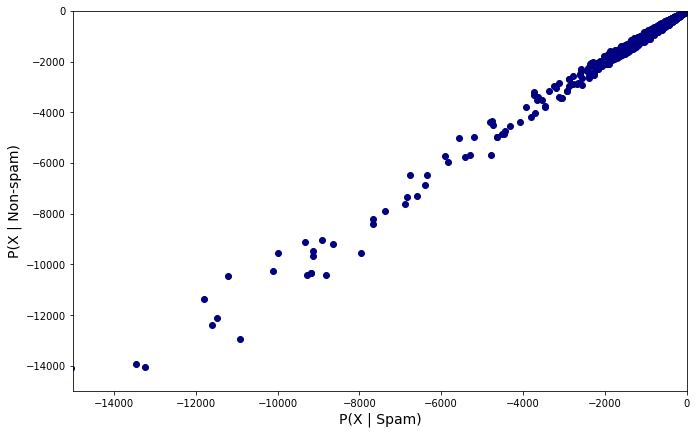

In [ ]:
plt.figure(figsize = (11, 7))
plt.xlabel(xaxis_label, fontsize = 14)
plt.ylabel(yaxis_label, fontsize = 14)

plt.xlim([-15000, 1])
plt.ylim([-15000, 1])

plt.scatter(joint_log_spam, joint_log_ham, color = 'navy')
plt.show()

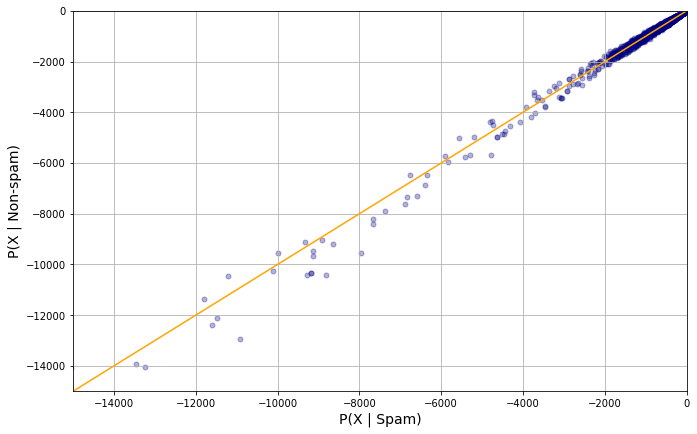

In [ ]:
plt.figure(figsize = (11, 7))
plt.xlabel(xaxis_label, fontsize = 14)
plt.ylabel(yaxis_label, fontsize = 14)

plt.xlim([-15000, 1])
plt.ylim([-15000, 1])

plt.scatter(joint_log_spam, joint_log_ham, color = 'navy', alpha = 0.3, s = 25)
plt.plot(linedata, linedata, color = 'orange')               #Decision boundary

plt.grid()
plt.show()

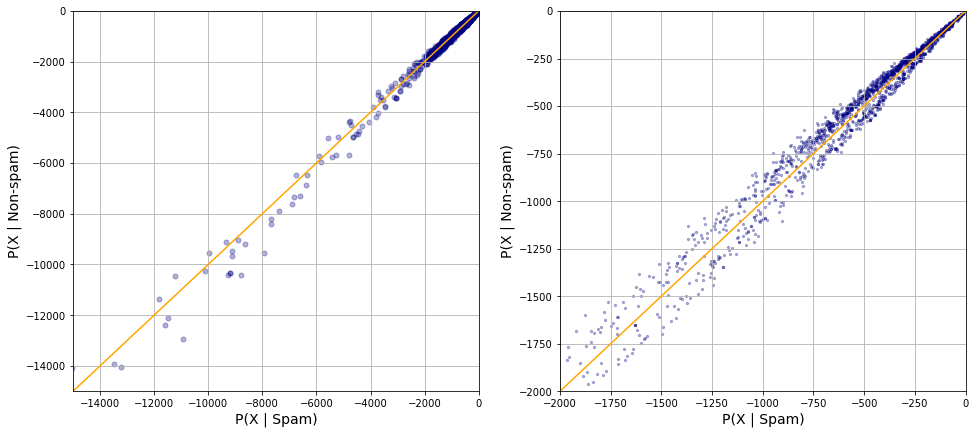

In [ ]:
plt.figure(figsize = (16, 7))

plt.subplot(1, 2, 1)

plt.xlabel(xaxis_label, fontsize = 14)
plt.ylabel(yaxis_label, fontsize = 14)

plt.xlim([-15000, 1])
plt.ylim([-15000, 1])

plt.scatter(joint_log_spam, joint_log_ham, color = 'navy', alpha = 0.3, s = 25) # alpha is for transparency, and s is the size
plt.plot(linedata, linedata, color = 'orange')               #Decision boundary
plt.grid()

# For the second plot
plt.subplot(1, 2, 2)

plt.xlabel(xaxis_label, fontsize = 14)
plt.ylabel(yaxis_label, fontsize = 14)

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.scatter(joint_log_spam, joint_log_ham, color = 'navy', alpha = 0.3, s = 5) # alpha is for transparency, and s is the size
plt.plot(linedata, linedata, color = 'orange')               #Decision boundary

plt.grid()
plt.show()

In [ ]:
# Chart Styling
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({yaxis_label: joint_log_ham, xaxis_label: joint_log_ham, labels: y_test})

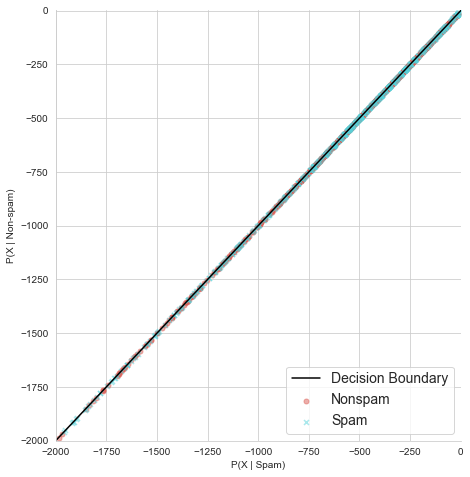

In [ ]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, height=6.5, fit_reg=False, legend=False, 
          scatter_kws={'alpha': 0.5, 's': 25}, hue=labels, markers=['o', 'x'], palette='hls')

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.plot(linedata, linedata, color = 'black')

plt.legend(('Decision Boundary', 'Nonspam', 'Spam'), loc = 'lower right', fontsize = 14)

plt.show()

**NOTE:** While visualizing, it is advisable not to use certain colour combinations like blue-green, as to take consideration of colour-blind people.

For getting different colour combinations used by artists, you can get their hex codes at http://colorlisa.com/

## False Positives and False Negatives

In [ ]:
np.unique(prediction, return_counts=True)

(array([False,  True]), array([1136,  588], dtype=int64))

In [ ]:
true_pos = (y_test == 1) & (prediction == 1)
true_pos.sum()

569

In [ ]:
false_pos = (y_test == 0) & (prediction == 1)
false_pos.sum()

19

In [ ]:
true_neg = (y_test == 0) & (prediction == 0)
true_neg.sum()

1116

In [ ]:
false_neg = (y_test == 1) & (prediction == 0)
false_neg.sum()

20

## Precision and Recall score

In [ ]:
recall_score = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print('Recall score is {:.2%}'.format(recall_score))

Recall score is 96.60%


In [ ]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print("Precision score is {:.3%}".format(precision_score))

Precision score is 96.769%


## F-score (or F1 Score)

In [ ]:
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print("F score is {:.2}".format(f1_score))

F score is 0.97


**NOTE:** Spam filters nowadays have evolved to a great extent. Not only do they take into account the email message, but they also look at the headers (for false/tampered headers) and prepare spammer blacklists by looking into the IP addresses of the spammers.